In [1]:
import pandas as pd
import os
import numpy as np
import json

import seaborn as sns
sns.set_style("white")
from evalutils.roc import get_bootstrapped_roc_ci_curves
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
import utils

%matplotlib inline
import sklearn.metrics as skl_metrics
from IPython.display import display, Markdown

import scipy.stats

## directory where results are
EXPERIMENT_DIR = f"/data/bodyct/experiments/lung-malignancy-fairness-shaurya"
NLST_PREDS = f"{EXPERIMENT_DIR}/nlst"

TEAMS_DIR = "C:/Users/shaur/OneDrive - Radboudumc/Documents - Master - Shaurya Gaur/General/Malignancy-Estimation Results/nlst"
NLST_PREDS = TEAMS_DIR ## Comment out if not using Teams backup (aka Chansey is up :)

In [2]:
kiran_nodule = pd.read_csv(f"{NLST_PREDS}/nlst_demov3_allmodels.csv")
kiran_data = utils.prep_nlst_preds(kiran_nodule, scanlevel=True, sybil=False, tijmen=False)
print(len(kiran_data), "Scans")

10183 Scans


In [3]:
with open(f'{NLST_PREDS}/nlst_demo_v3_cols.json') as json_data:
    nlst_democols = json.load(json_data)
    json_data.close()

In [4]:
nlst_democols['cat'].pop('nodule')
nlst_democols['num'].pop('nodule')
nlst_democols

{'num': {'demo': ['height', 'weight', 'Age', 'BMI'],
  'smoke': ['pkyr', 'smokeage', 'smokeday', 'smokeyr'],
  'other': ['NoduleCounts', 'Diameter [mm]']},
 'cat': {'demo': ['marital',
   'educat',
   'race',
   'ethnic',
   'Gender',
   'Married',
   'NonHispanicWhite',
   'HighSchoolPlus'],
  'smoke': ['cigar', 'cigsmok', 'pipe', 'smokelive', 'smokework'],
  'work': ['wrkasbe',
   'wrkbaki',
   'wrkbutc',
   'wrkchem',
   'wrkcoal',
   'wrkcott',
   'wrkfarm',
   'wrkfire',
   'wrkflou',
   'wrkfoun',
   'wrkhard',
   'wrkpain',
   'wrksand',
   'wrkweld'],
  'disease': ['diagadas',
   'diagasbe',
   'diagbron',
   'diagchas',
   'diagchro',
   'diagcopd',
   'diagdiab',
   'diagemph',
   'diagfibr',
   'diaghear',
   'diaghype',
   'diagpneu',
   'diagsarc',
   'diagsili',
   'diagstro',
   'diagtube'],
  'canchist': ['cancblad',
   'cancbrea',
   'canccerv',
   'canccolo',
   'cancesop',
   'canckidn',
   'canclary',
   'canclung',
   'cancnasa',
   'cancoral',
   'cancpanc',
   'c

In [5]:
cols_num = sum(nlst_democols['num'].values(), start=[])
cols_cat = sum(nlst_democols['cat'].values(), start=[])
cols_list = cols_num + cols_cat

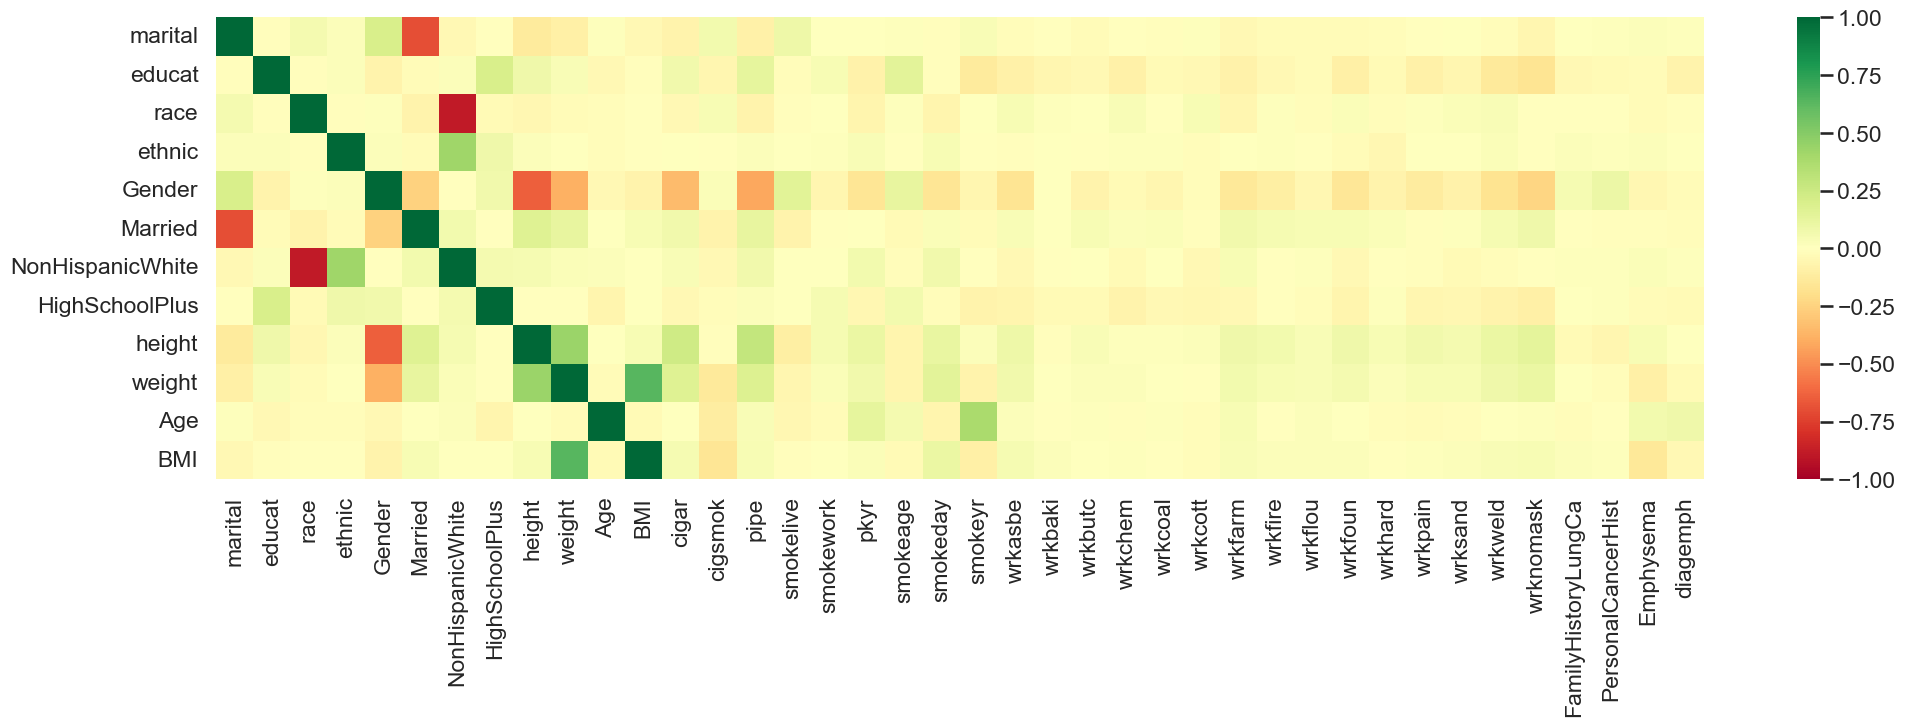

In [6]:
# corrmat = kiran_data[cols_list].corr(method='kendall').round(2)
corr_rows = nlst_democols['cat']['demo'] + nlst_democols['num']['demo']
corr_cols = corr_rows + nlst_democols['cat']['smoke'] + nlst_democols['num']['smoke'] + nlst_democols['cat']['work'] + nlst_democols['cat']['other'] + ['diagemph']

corrmat = utils.corrmat(kiran_data, corr_rows, corr_cols)

In [7]:
def testlink_cat_cat(df0, col1, col2, debug=False):
    df = df0.dropna(subset=[col1, col2], axis=0)
    if debug: display(Markdown(f"### {col1} and {col2}"))
    contingency_table = pd.crosstab(df[col1], df[col2])
    if debug: display(contingency_table)

    chi2_result = scipy.stats.chi2_contingency(contingency_table)
    if debug: 
        print("stat:\t", chi2_result.statistic)
        print("pval:\t", chi2_result.pvalue)
        print("dof:\t", chi2_result.dof)

    cramer_v = scipy.stats.contingency.association(contingency_table, method='cramer')
    if debug: print("Cramer:\t", cramer_v)
    return cramer_v, chi2_result.pvalue

testlink_cat_cat(kiran_data, 'Married', 'Gender', debug=True)

### Married and Gender

Gender,1,2
Married,,
False,1303,2025
True,4531,2324


stat:	 663.6672470325547
pval:	 2.3812298985172768e-146
dof:	 1
Cramer:	 0.25550369525856476


(0.25550369525856476, np.float64(2.3812298985172768e-146))

In [8]:
### Pearson correlation
def testlink_num_num(df0, col1, col2, debug=False, r_func=scipy.stats.kendalltau):
    if debug: display(Markdown(f"### {col1} and {col2}"))
    df = df0.dropna(subset=[col1, col2], axis=0)
    stat, pval = r_func(df[col1], df[col2], alternative='two-sided')
    if debug: 
        print("stat:\t", stat)
        print("pval:\t", pval)
    return stat, pval

testlink_num_num(kiran_data, 'Age', 'weight', debug=True)

### Age and weight

stat:	 -0.024219494908991723
pval:	 0.0004071353068128385


(np.float64(-0.024219494908991723), np.float64(0.0004071353068128385))

In [9]:
def testlink_cat_num(df0, col_cat, col_num, debug=False):
    if debug: display(Markdown(f"### {col_cat} and {col_num}"))
    df = df0.dropna(subset=[col_cat, col_num], axis=0)
    dfbycat = df.groupby(col_cat)
    samples = {val: dfg[col_num] for val, dfg in dfbycat}

    if debug:
        for val in samples:
            display(Markdown(f"#### {val}"))
            print("mean:", samples[val].mean())
            print("std:", samples[val].std())
            print("median:", samples[val].median())
    
    stat, pval = scipy.stats.kruskal(*list(samples.values()), axis=0)
    display(Markdown(f"#### Kruskal-Wallis H-test results"))
    if debug: 
        print("stat:\t", stat)
        print("pval:\t", pval)
    
    return stat, pval

testlink_cat_num(kiran_data, 'Married', 'Age', debug=True)

### Married and Age

#### False

mean: 63.18088942307692
std: 5.236892107365422
median: 63.0


#### True

mean: 63.21663019693654
std: 5.242044901299023
median: 62.0


#### Kruskal-Wallis H-test results

stat:	 0.07758086433532128
pval:	 0.7806029165434643


(np.float64(0.07758086433532128), np.float64(0.7806029165434643))

In [10]:
MODEL_TO_COL = {
    "Venkadesh": "DL",
    "de Haas Combined": "Thijmen_mean",
    "de Haas Local": "Thijmen_local",
    "de Haas Global (hidden nodule)": "Thijmen_global_hidden",
    "de Haas Global (shown nodule)": "Thijmen_global_show",
    "Sybil year 1": "sybil_year1",
    "Sybil year 2": "sybil_year2",
    "Sybil year 3": "sybil_year3",
    "Sybil year 4": "sybil_year4",
    "Sybil year 5": "sybil_year5",
    "Sybil year 6": "sybil_year6",
    "PanCan2b": "PanCan2b",
}

In [11]:
set_cat = set(cols_cat + ['label'])
set_num = set(cols_num + list(MODEL_TO_COL.values()))
len(set_num), len(set_cat), len(set_cat.intersection(set_num))

(22, 63, 0)

In [12]:
def pval_corr_value(df, col1, col2, debug=False):
    col1type = "cat" if (col1 in set_cat) else "num"
    col2type = "cat" if (col2 in set_cat) else "num"
    types = sorted([col1type, col2type])

    if debug:
        print(f"{col1} is {col1type}")
        print(f"{col2} is {col2type}")
    
    if types == ['cat', 'cat']: stat, pval = testlink_cat_cat(df, col1, col2, debug)
    if types == ['num', 'num']: stat, pval = testlink_num_num(df, col1, col2, debug)
    if col1type == 'cat' and col2type == 'num':
        stat, pval = testlink_cat_num(df, col1, col2, debug)
    if col2type == 'cat' and col1type == 'cat':
        stat, pval = testlink_cat_num(df, col2, col1, debug)
    
    return 1 - abs(pval)

In [13]:
def pval_corr_callable(arr1, arr2):
    if pd.Series(arr1).equals(pd.Series(arr2)): return 1
    df = pd.DataFrame({"var1": arr1, 'var2': arr2})
    return pval_corr_value(df, "var1", "var2", debug=False)

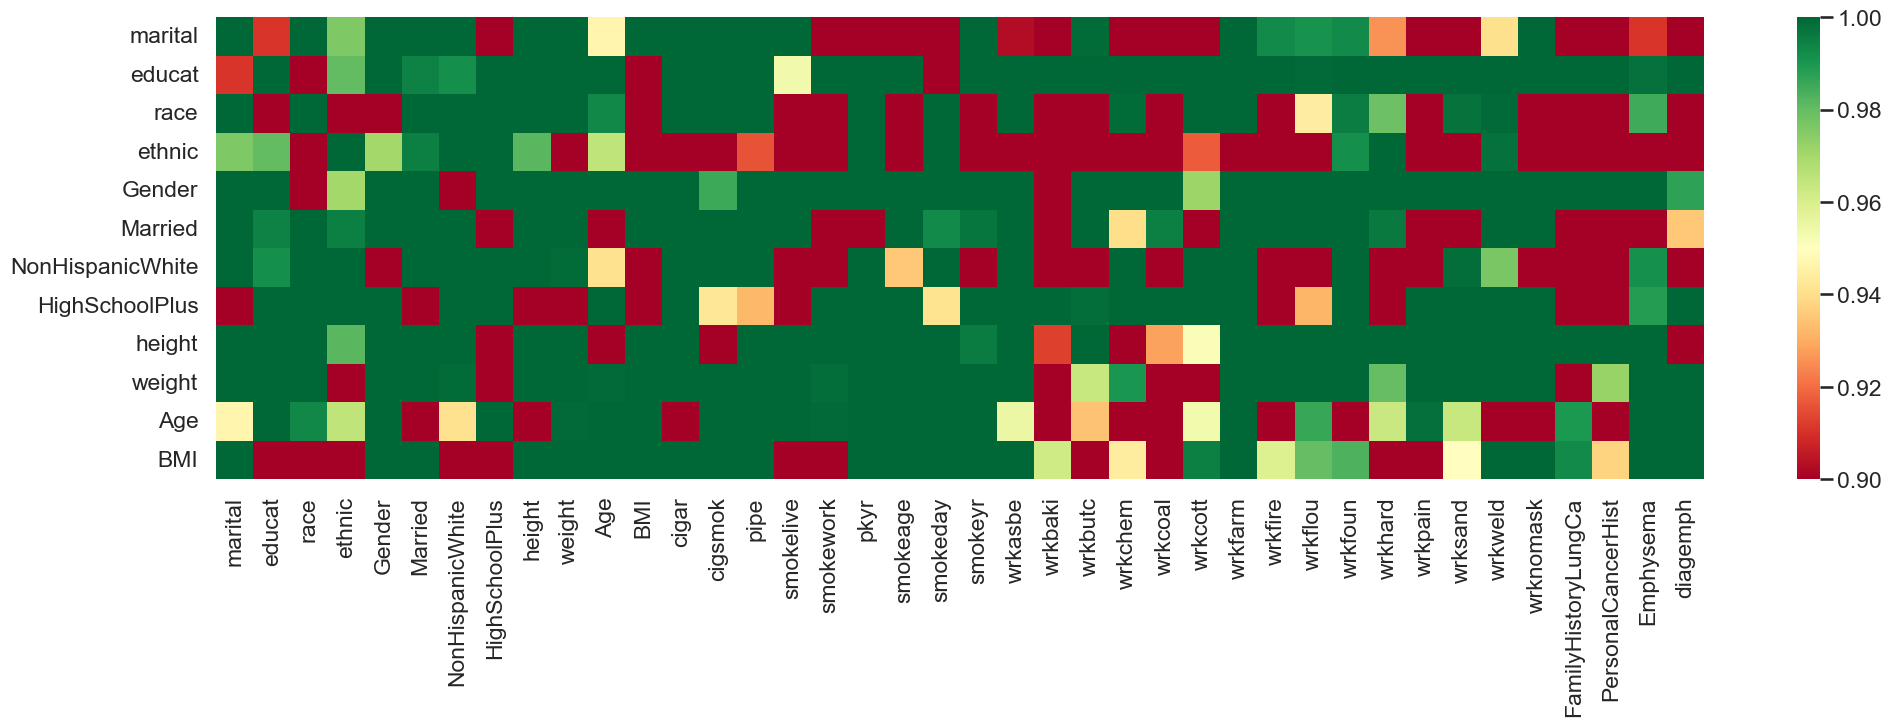

,wrkbutc,wrkfoun,cigar,wrkflou,wrkasbe,Age,wrksand,FamilyHistoryLungCa,pkyr,wrkcoal,...,weight,wrkfarm,wrkcott,wrkhard,Gender,marital,HighSchoolPlus,smokeyr,height,cigsmok
wrkbutc,1.000000,1.000000,1.000000,1.000000,0.995004,0.934331,0.999998,0.974166,0.887911,0.957795,...,0.963458,1.000000,1.000000,0.969971,1.000000,0.998902,0.998749,0.988996,0.999935,0.775123
wrkfoun,1.000000,1.000000,1.000000,1.000000,1.000000,0.129902,1.000000,0.654948,0.998907,1.000000,...,1.000000,1.000000,0.154397,1.000000,1.000000,0.992634,1.000000,0.998945,1.000000,0.978593
cigar,1.000000,1.000000,1.000000,0.999861,1.000000,0.635642,1.000000,0.812569,1.000000,0.135274,...,1.000000,1.000000,0.596219,0.987341,1.000000,1.000000,0.999992,0.469228,1.000000,1.000000
wrkflou,1.000000,1.000000,0.999861,1.000000,0.995277,0.986290,0.999953,0.994161,0.738351,0.999551,...,0.999901,1.000000,0.999994,1.000000,1.000000,0.990853,0.931268,0.999501,0.999874,0.765456
wrkasbe,0.995004,1.000000,1.000000,0.995277,1.000000,0.954918,1.000000,0.992657,1.000000,1.000000,...,1.000000,0.999999,0.404758,1.000000,1.000000,0.902973,1.000000,1.000000,1.000000,0.254645
Age,0.934331,0.129902,0.635642,0.986290,0.954918,1.000000,0.963657,0.989782,1.000000,0.790924,...,0.999593,1.000000,0.953254,0.963251,0.999999,0.946863,1.000000,1.000000,0.569466,1.000000
wrksand,0.999998,1.000000,1.000000,0.999953,1.000000,0.963657,1.000000,0.209421,0.987201,0.999564,...,1.000000,1.000000,0.999998,1.000000,1.000000,0.235102,1.000000,0.998850,1.000000,0.815274
FamilyHistoryLungCa,0.974166,0.654948,0.812569,0.994161,0.992657,0.989782,0.209421,1.000000,0.999921,0.903714,...,0.027128,0.935531,0.999883,0.321793,1.000000,0.400381,0.553453,0.860850,0.999974,0.032583
pkyr,0.887911,0.998907,1.000000,0.738351,1.000000,1.000000,0.987201,0.999921,1.000000,0.828548,...,1.000000,0.999211,0.999206,0.965957,1.000000,0.590427,1.000000,1.000000,1.000000,0.967412
wrkcoal,0.957795,1.000000,0.135274,0.999551,1.000000,0.790924,0.999564,0.903714,0.828548,1.000000,...,0.285613,0.999961,0.999950,1.000000,1.000000,0.889173,0.999998,0.966382,0.928415,0.220023


In [15]:
utils.corrmat(kiran_data, corr_rows, corr_cols, method=pval_corr_callable, vmin=0.9, vmax=1)